In [1]:
#from IPython import clear_output
from IPython.display import clear_output
!bash -c "source ~/catkin_ws/devel/setup.bash && env"
clear_output()

In [2]:
import sys
print(sys.executable)
print(sys.version)


/bin/python3
3.8.10 (default, Nov  7 2024, 13:10:47) 
[GCC 9.4.0]


In [3]:

import os
import rospy
import sys
import time
import numpy as np
import cv2
import math
import scipy
import rosbag


In [4]:
def read_bags(root_dir='User_data_with_video', limit = 300, start_num = 232):
    """
    Extracts data from all ROS bag files under subfolders user_<number> within the given root directory.
    
    The returned dictionary has the form:
        data[user_number][topic_name] = list of message objects
    
    :param root_dir: The directory containing subfolders named user_<number> with .bag files.
    :return: A nested dictionary of the extracted data.
    """
    
    data = {}
    id_index = []
    cnt = 0
    # List all items in root_dir
    for folder_name in os.listdir(root_dir):
        # We are only interested in folders that start with "user_"
        if folder_name.startswith("user_") and folder_name.split("_", 1)[1] >= str(start_num):
            cnt += 1
            # Extract the user number from folder name (e.g., user_100 -> "100")
            user_number = folder_name.split("_", 1)[1]
            id_index.append(user_number)
            user_dir = os.path.join(root_dir, folder_name)
            
            # Make sure it's actually a directory
            if not os.path.isdir(user_dir):
                continue
            
            # Initialize a dictionary for this user
            data[user_number] = {}
            
            # Find all .bag files inside this user directory
            bag_files = [
                f for f in os.listdir(user_dir)
                if f.endswith(".bag") and os.path.isfile(os.path.join(user_dir, f))
            ]
            
            for bag_file in bag_files:
                bag_path = os.path.join(user_dir, bag_file)
                
                print(f"Processing bag: {bag_path}")
                
                # Open the bag
                with rosbag.Bag(bag_path, 'r') as bag:
                    # Read all messages (topic, message, timestamp)
                    for topic, msg, t in bag.read_messages():
                        # If topic is not yet in data dict, initialize it
                        # if the topic contains camera_ then skip it
                        if topic not in data[user_number] and topic.find('camera') == -1:
                            data[user_number][topic] = []
                        
                        # Append the message to the list for this topic
                        if topic.find('camera') == -1:
                            data[user_number][topic].append(msg)
            if cnt > limit:
                break
    
    return data, id_index




data, id_index = read_bags('video_free_bags', 120)
print("Data extraction complete.")
print(f"Extracted data for {len(data)} users.")
print(f"User IDs: {id_index}")
print(f"Data keys: {data[id_index[0]].keys()}")





Processing bag: video_free_bags/user_252/user_252.bag
Processing bag: video_free_bags/user_239/user_239.bag
Processing bag: video_free_bags/user_312/user_312.bag
Processing bag: video_free_bags/user_314/user_314.bag
Processing bag: video_free_bags/user_247/user_247.bag
Processing bag: video_free_bags/user_277/user_277.bag
Processing bag: video_free_bags/user_310/user_310.bag
Processing bag: video_free_bags/user_240/user_240.bag
Processing bag: video_free_bags/user_323/user_323.bag
Processing bag: video_free_bags/user_285/user_285.bag
Processing bag: video_free_bags/user_272/user_272.bag
Processing bag: video_free_bags/user_302/user_302.bag
Processing bag: video_free_bags/user_253/user_253.bag
Processing bag: video_free_bags/user_322/user_322.bag
Processing bag: video_free_bags/user_254/user_254.bag
Processing bag: video_free_bags/user_325/user_325.bag
Processing bag: video_free_bags/user_304/user_304.bag
Processing bag: video_free_bags/user_260/user_260.bag
Processing bag: video_free_b

In [5]:

def write_bags(data, id_index, output_dir='User_data_output'):
    """
    Writes the data from the nested dictionary to ROS bag files, creating one bag per user.
    
    :param data: The nested dictionary returned by read_bags(), 
                 structured as data[user_number][topic_name] = list of message objects.
    :param id_index: The list of user IDs.
    :param output_dir: The directory to store the newly created user_<id> folders and bag files.
    """
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Iterate through each user in our data
    for user_number in id_index:
        
        # Create a subdirectory for this user
        user_folder_name = f"user_{user_number}"
        user_dir = os.path.join(output_dir, user_folder_name)
        if not os.path.exists(user_dir):
            os.makedirs(user_dir)
        
        # We'll create a single bag file per user. Adjust naming as you wish.
        bag_file_name = f"user_{user_number}.bag"
        bag_path = os.path.join(user_dir, bag_file_name)
        
        print(f"Writing bag for user_{user_number} at: {bag_path}")
        
        # Open the bag for writing
        with rosbag.Bag(bag_path, 'w') as bag:
            # For each topic, write all messages into the bag
            for topic in data[user_number].keys():
                msg_list = data[user_number][topic]
                # If the original code doesn't store timestamps, create dummy ones.
                for idx, msg in enumerate(msg_list):
                    # Create a fake timestamp
                    # e.g., incremental or based on index
                    stamp = rospy.Time.from_sec(idx * 0.01)
                    bag.write(topic, msg, stamp)
                    
        print(f"Finished writing bag for user_{user_number}.\n")

# write_bags(data, id_index, 'video_free_bags')

In [6]:
import pandas as pd

# 1) Read your CSV file into a DataFrame
# Replace "my_file.csv" with the actual path/filename
df = pd.read_csv("Data Annotation.csv")

# Make sure the "User ID" column is interpreted consistently
# (if your CSV has a header named 'User ID' exactly, this should work as is)
df['User ID'] = df['User ID'].astype(str)

for user_id in id_index:
    # user_id is a string (e.g. "234"), so we converted CSV's 'User ID' to string above
    match = df.loc[df['User ID'] == user_id]
    
    if not match.empty:
        # 3) Attach relevant CSV columns to your data dict
        # In the CSV snippet you shared, columns include 'Success Time', 'Demo Quality', etc.
        # For example, attach them under data[user_id]['csv_info'] or something similar:
        row = match.iloc[0]  # if there's exactly one match
        data[user_id]['csv_info'] = {
            'Success': row['Success'],
            'Start Location': row['Start Location'],
            'Success Time': row['Success Time '],
            'Demo Quality': row['Demo Quality (0 to 2)'],
            'Practice Behavior': row['Practice Behavior? (0, 1)'],
            'Novel Policy': row['Novel Policy? (0, 1)'],
            'Self Reported Expertise': row['Self Reported Expertise'],
            'Note': row['Note'],
        }
    else:
        # Handle the case where the CSV has no row for this user
        # e.g. just continue or fill in None
        data[user_id]['csv_info'] = None


# print(data['310']['csv_info'])

# #remove data[291] and data[292]



In [7]:
data.pop('291')
data.pop('292')

id_index.remove('291')
id_index.remove('292')

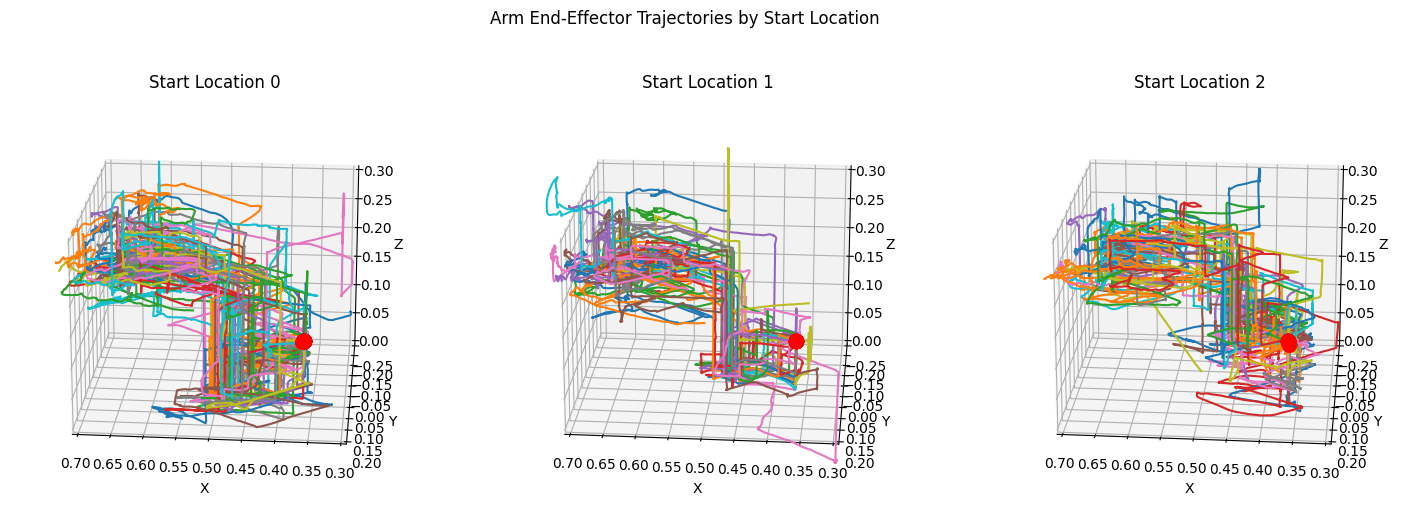

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting in older matplotlib
import numpy as np

def plot_arm_trajectories(ax, data, user_ids, topic='/my_gen3_lite/base_feedback'):
    """
    Plots the end-effector (tool) trajectory for the given user_ids on a provided 3D axis.
    """
    for user_number in user_ids:
        # Check if the topic exists for this user
        if topic not in data[user_number]:
            print(f"Topic '{topic}' not found for user {user_number}. Skipping...")
            continue
        
        x_vals = []
        y_vals = []
        z_vals = []

        # Extract the tool pose from each feedback message
        for msg in data[user_number][topic]:
            # Each msg is presumably a feedback message with:
            #   msg.base.tool_pose_x, msg.base.tool_pose_y, msg.base.tool_pose_z
            x_vals.append(msg.base.tool_pose_x)
            y_vals.append(msg.base.tool_pose_y)
            z_vals.append(msg.base.tool_pose_z)
        
        # Convert to numpy arrays (optional)
        x_vals = np.array(x_vals)
        y_vals = np.array(y_vals)
        z_vals = np.array(z_vals)

        # Plot the 3D trajectory for this user on the given axis
        ax.plot(x_vals, y_vals, z_vals, label=f"User {user_number}")

        # add a dot at the start and end of the trajectory, set marker size to 10
        ax.scatter(x_vals[0], y_vals[0], z_vals[0], c='r', marker='o', s=100)
        #ax.scatter(x_vals[-1], y_vals[-1], z_vals[-1], c='g', marker='o')

    # If you want a legend for each subplot:
    # ax.legend()

# Now create a 1×3 figure with 3D subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': '3d'})

# Loop through the 3 start locations (assumed to be 0, 1, 2)
for i in range(3):
    # Collect all user_ids for the given start location
    user_list = [uid for uid in id_index if data[uid]['csv_info']['Start Location']!=None and data[uid]['csv_info']['Start Location'] == i]
    
    # Plot on the i-th axis
    plot_arm_trajectories(axs[i], data, user_list, topic='/my_gen3_lite/base_feedback')
    
    # Set labels and title for each subplot
    axs[i].set_xlabel("X")
    axs[i].set_ylabel("Y")
    axs[i].set_zlabel("Z")
    axs[i].set_title(f"Start Location {i}")
    # set x y z limits to be the same
    axs[i].set_xlim(0.3, 0.7)
    axs[i].set_ylim(-0.25, 0.2)
    axs[i].set_zlim(0, 0.3)

    # set view angle
    axs[i].view_init(azim=95, elev=20)

plt.suptitle("Arm End-Effector Trajectories by Start Location")
plt.show()


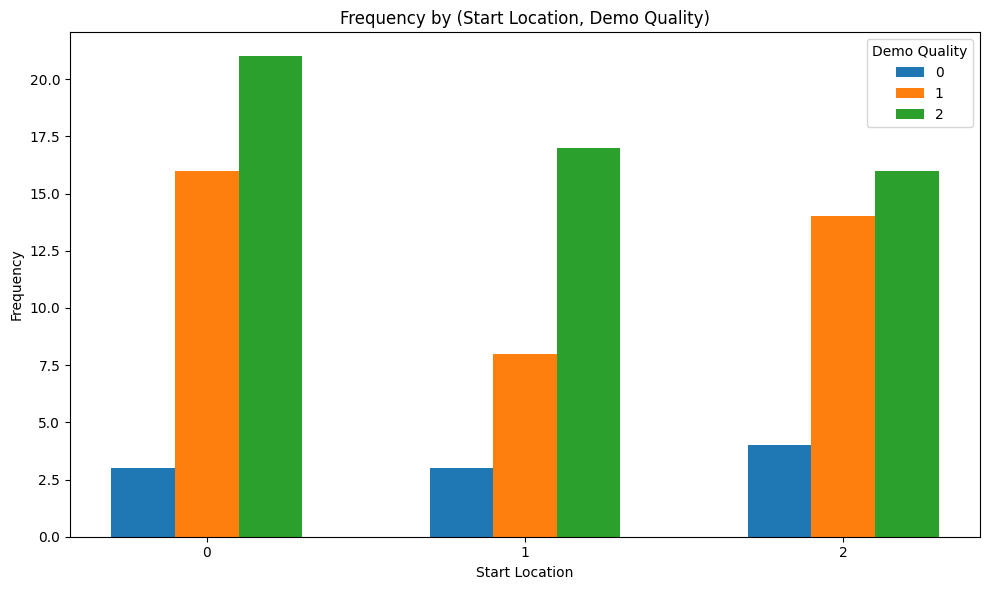

In [9]:
import matplotlib.pyplot as plt
import numpy as np


counts = {}
start_locs = set()
demo_quals = set()

for user_number in id_index:
    sl = data[user_number]['csv_info']['Start Location']
    dq = data[user_number]['csv_info']['Demo Quality']
    start_locs.add(sl)
    demo_quals.add(dq)
    counts[(sl, dq)] = counts.get((sl, dq), 0) + 1

# Convert sets to sorted lists so the bars appear in a consistent order
start_locs = sorted(start_locs)      # e.g. [0, 1, 2]
demo_quals = sorted(demo_quals)     # e.g. ["Low", "Medium", "High"]


x = np.arange(len(start_locs))  # x-coordinates for each group
bar_width = 0.2                 # width of each bar
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Example colors for the 3 qualities

fig, ax = plt.subplots(figsize=(10, 6))


for i, dq in enumerate(demo_quals):
    # Build the frequency array for this demo quality across all start locations
    freq_list = [counts.get((sl, dq), 0) for sl in start_locs]
    
    # Offset each bar group by i*bar_width
    ax.bar(x + i*bar_width, freq_list, 
           width=bar_width, 
           label=str(dq), 
           color=colors[i % len(colors)])


ax.set_xticks(x + bar_width*(len(demo_quals)-1)/2)
ax.set_xticklabels(start_locs)

ax.set_xlabel("Start Location")
ax.set_ylabel("Frequency")
ax.set_title("Frequency by (Start Location, Demo Quality)")

ax.legend(title="Demo Quality")

plt.tight_layout()
plt.show()


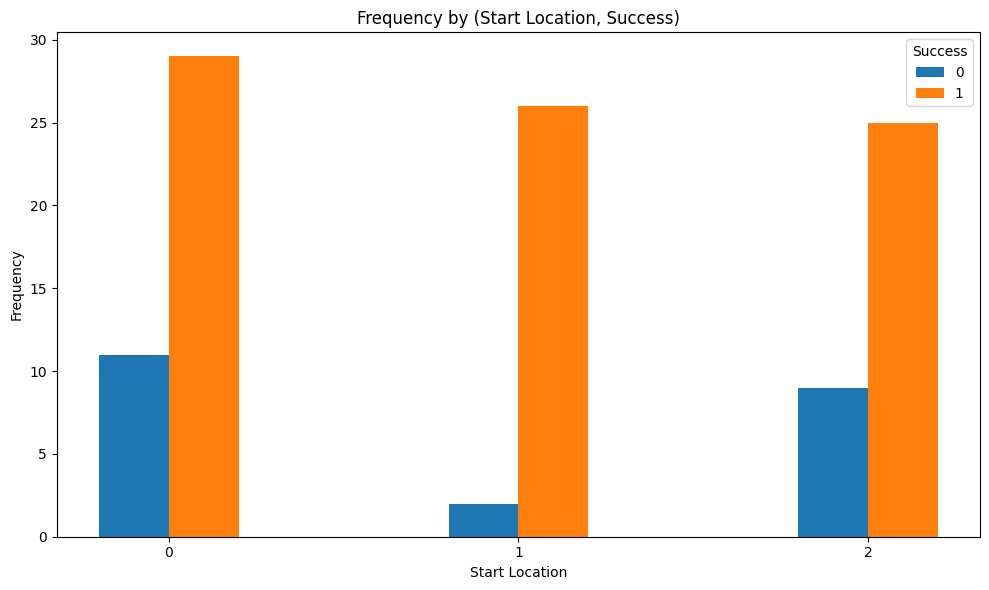

In [10]:
# plot the success rate by start location

counts = {}
start_locs = set()
successes = set()

for user_number in id_index:
    sl = data[user_number]['csv_info']['Start Location']
    success = data[user_number]['csv_info']['Success']
    start_locs.add(sl)
    successes.add(success)
    counts[(sl, success)] = counts.get((sl, success), 0) + 1

# Convert sets to sorted lists so the bars appear in a consistent order
start_locs = sorted(start_locs)      # e.g. [0, 1, 2]
successes = sorted(successes)     # e.g. ["Low", "Medium", "High"]

x = np.arange(len(start_locs))  # x-coordinates for each group
bar_width = 0.2                 # width of each bar
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Example colors for the 3 qualities

fig, ax = plt.subplots(figsize=(10, 6))

for i, success in enumerate(successes):
    # Build the frequency array for this demo quality across all start locations
    freq_list = [counts.get((sl, success), 0) for sl in start_locs]
    
    # Offset each bar group by i*bar_width
    ax.bar(x + i*bar_width, freq_list, 
           width=bar_width, 
           label=str(success), 
           color=colors[i % len(colors)])
    
ax.set_xticks(x + bar_width*(len(successes)-1)/2)
ax.set_xticklabels(start_locs)

ax.set_xlabel("Start Location")
ax.set_ylabel("Frequency")
ax.set_title("Frequency by (Start Location, Success)")

ax.legend(title="Success")

plt.tight_layout()
plt.show()


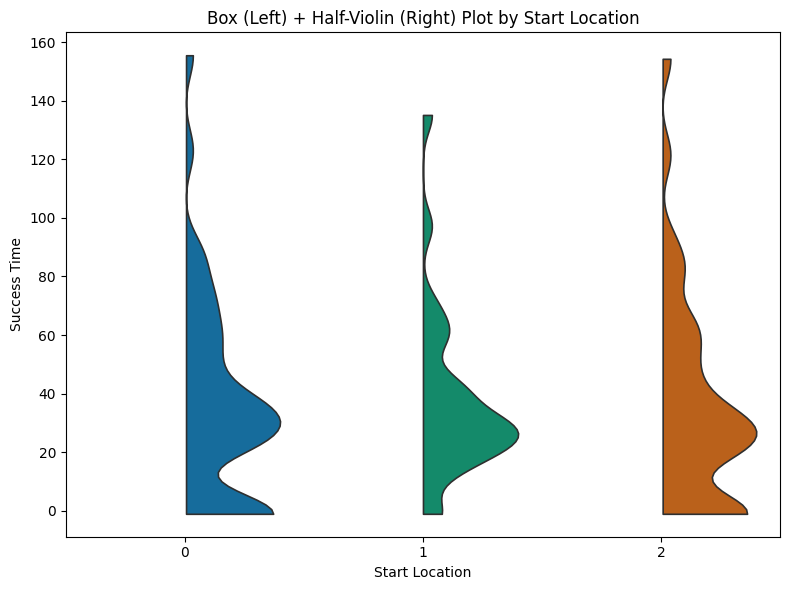

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Choose a color palette for each Start Location
palette = ["#0072B2", "#009E73", "#D55E00"]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# boxplot = sns.boxplot(
#     x="Start Location",
#     y="Success Time",
#     data=df,
#     width=0.4,            # narrower boxes
#     palette=palette,      # match colors with the half-violin
#     whis=1.5,
#     fliersize=0,         # hide outlier fliers, or set smaller if you like
#     linewidth=1.2,
#     boxprops={"zorder": 3},  # ensure boxes are on top of the violin fill
#     dodge=False
# )

violinplot = sns.violinplot(
    x="Start Location",
    y="Success Time",
    data=df,
    palette=palette,
    cut=0,
    scale="width",
    bw=0.2,
    inner=None,    # no internal lines/box
    width=0.8,     # a bit wider so we can see the half extended to the right
    linewidth=1.2,
    dodge=False
)


all_collections = ax.collections
num_categories = df["Start Location"].nunique()

violin_index = 0
for c in all_collections:
    if violin_index >= num_categories:
        break
    # Each "violin" is a PolyCollection with a single path that outlines the shape.
    # Some Seaborn versions produce multiple paths; we'll check for that.
    paths = getattr(c, 'get_paths', lambda: [])()
    if not paths:
        continue  # skip non-violin objects
    
    path = paths[0]
    vertices = path.vertices
    # The median x-value is effectively the "spine" of the violin
    median_x = np.median(vertices[:, 0])
    # Clip left side to the median
    vertices[:, 0] = np.clip(vertices[:, 0], median_x, None)
    
    violin_index += 1


ax.set_xlabel("Start Location")
ax.set_ylabel("Success Time")
ax.set_title("Box (Left) + Half-Violin (Right) Plot by Start Location")

plt.tight_layout()
plt.show()


In [22]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr



# 1) Correlation between self-report expertise and demo quality
expertise = []
demo_quality = []

for user_number in id_index:
    if data[user_number]['csv_info'] is not None:
        expertise.append(data[user_number]['csv_info']['Self Reported Expertise'])
        demo_quality.append(data[user_number]['csv_info']['Demo Quality'])

# Convert to numpy arrays for easier handling
expertise = np.array(expertise)
demo_quality = np.array(demo_quality)

# Calculate the Pearson correlation coefficient
corr, p_value = pearsonr(expertise, demo_quality)
print(f"Pearson correlation coefficient: {corr:.3f}")

# 2) Correlation between success time and demo quality
success_time = []
demo_quality = []

for user_number in id_index:
    if data[user_number]['csv_info'] is not None:
        success_time.append(data[user_number]['csv_info']['Success Time'])
        demo_quality.append(data[user_number]['csv_info']['Demo Quality'])

# Convert to numpy arrays for easier handling
success_time = np.array(success_time)
demo_quality = np.array(demo_quality)

# Calculate the Pearson correlation coefficient
corr, p_value = pearsonr(success_time, demo_quality)
print(f"Pearson correlation coefficient: {corr:.3f}")

# 3) Correlation between success time and self-report expertise
success_time = []
expertise = []

for user_number in id_index:
    if data[user_number]['csv_info'] is not None:
        success_time.append(data[user_number]['csv_info']['Success Time'])
        expertise.append(data[user_number]['csv_info']['Self Reported Expertise'])

# Convert to numpy arrays for easier handling
success_time = np.array(success_time)
expertise = np.array(expertise)

# Calculate the Pearson correlation coefficient
corr, p_value = pearsonr(success_time, expertise)
print(f"Pearson correlation coefficient: {corr:.3f}")




Pearson correlation coefficient: 0.179
Pearson correlation coefficient: 0.029
Pearson correlation coefficient: -0.282
